Based on model of scattering off dirac potential on sublattice A
Dutreix 2019

### Imports and Constants

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import hankel1
from scipy.integrate import quad
from scipy.optimize import fsolve

from tqdm import tqdm

In [25]:
# This constant C is global and is used throughout the paper
# Other constants are from pybinding documentation on graphene
C = 1
VF = 906091185689731.9 #nm/s Speed of dirac fermions 
a = 0.24595 # nm Unit length cell of graphene
hbar = 6.582119569 * 1e-16 #eV s

V0 = -3 #eV Strength of the dirac potential

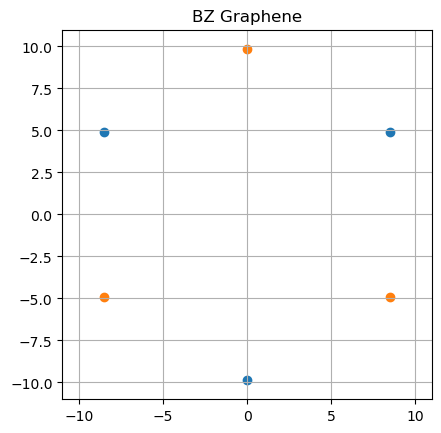

In [26]:
figt, axt = plt.subplots()

# Defining Graphene BZ

# From Graphene Tutorial
KC = (2 * np.pi) / (3 * a)

Kx, Ky = KC, KC * 1/np.sqrt(3)
KPx, KPy = KC, KC * -1/np.sqrt(3)

KR = np.sqrt(Kx ** 2 + Ky ** 2)

kvallyes = [[Kx, Ky], [-Kx, Ky], [0, -KR]]
kpvallyes = [[KPx, KPy], [-KPx, KPy], [0, KR]]

axt.scatter([Kx, -Kx, 0], [Ky, Ky, -KR])
axt.scatter([KPx, -KPx, 0], [KPy, KPy, KR])
axt.set_aspect("equal")
axt.set_xlim(-11, 11)
axt.set_ylim(-11, 11)
axt.set_title("BZ Graphene")
axt.grid()

### Hankel Functions

Text(0.5, 1.0, 'Hankel Function')

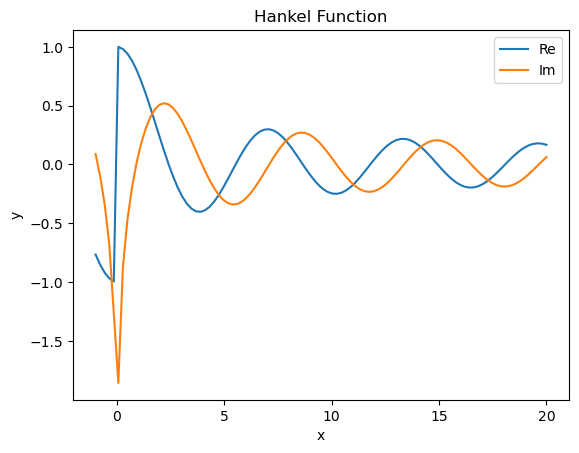

In [27]:
# The paper uses Hankel Functions of the FIRST kind
# syntax: scipy.special
xt = np.linspace(-1, 20, 100)

fig1, ax1 = plt.subplots()

ax1.plot(xt, np.real(hankel1(0, xt)))
ax1.plot(xt, np.imag(hankel1(0, xt)))
ax1.legend(["Re", "Im"])

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Hankel Function")

### Local Density of States

In [28]:
# Greens function AA element for PRISTINE graphene
def G0AA(q, w):
    return -1/(w ** 2 - (VF * q)**2) * (-w)

# Transfer Function
def t(w):
    dem = 1 - V0/hbar * G0AA(0, w) # units
    return V0/(dem*hbar)

In [29]:
# w is the energy of the electrons
# We input Vb in units [eV] then divide by hbar [ev][s]
def dRhoA(r, Vb):
    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(0, w * (r/VF)) ** 2), 0, Vb/(hbar))

def dRhoB(r, Vb):
    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(1, w * (r/VF)) ** 2), 0, Vb/(hbar))

Text(0.5, 1.0, 'C=1, V0= 1 eV, Vb = 0.8 eV')

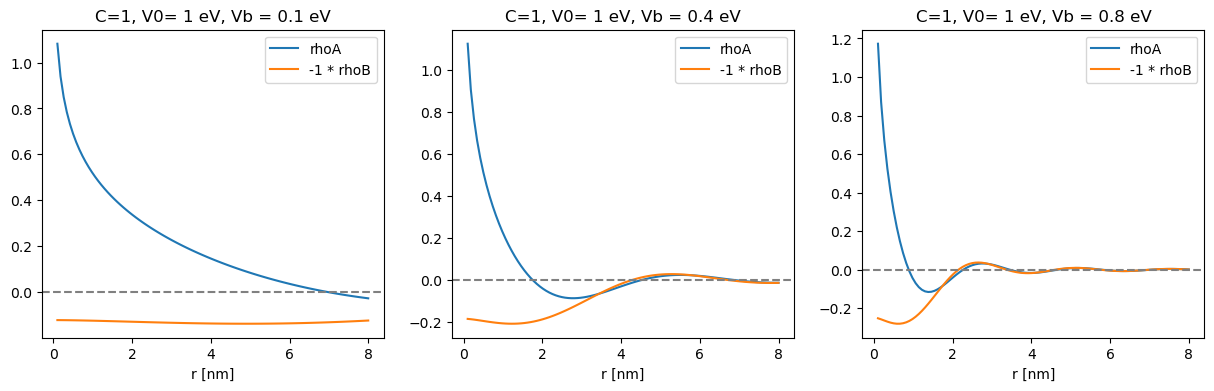

In [30]:
# Re Creating FIG S3 from Dutreix
rlist = np.linspace(0.1, 8, 100)

normalized = dRhoA(0.14, 0.1)[0]

# Input Vb in eV
y11 = np.array([dRhoA(r, 0.1)[0]/normalized for r in rlist])
y21 = np.array([-dRhoB(r, 0.1)[0]/normalized for r in rlist])

fig4, axs4 = plt.subplots(1, 3, figsize=(15, 4))

axs4[0].plot(rlist, y11)
axs4[0].plot(rlist, y21)

axs4[0].axhline(0, color="gray", linestyle="dashed")
axs4[0].legend(["rhoA", "-1 * rhoB"])
axs4[0].set_xlabel("r [nm]")

axs4[0].set_title("C=1, V0= 1 eV, Vb = 0.1 eV")

################

normalized = dRhoA(0.14, 0.4)[0]

# Input Vb in eV
y11 = np.array([dRhoA(r, 0.4)[0]/normalized for r in rlist])
y21 = np.array([-dRhoB(r, 0.4)[0]/normalized for r in rlist])

axs4[1].plot(rlist, y11)
axs4[1].plot(rlist, y21)

axs4[1].axhline(0, color="gray", linestyle="dashed")
axs4[1].legend(["rhoA", "-1 * rhoB"])
axs4[1].set_xlabel("r [nm]")

axs4[1].set_title("C=1, V0= 1 eV, Vb = 0.4 eV")

################

normalized = dRhoA(0.14, 0.8)[0]

# Input Vb in eV
y11 = np.array([dRhoA(r, 0.8)[0]/normalized for r in rlist])
y21 = np.array([-dRhoB(r, 0.8)[0]/normalized for r in rlist])

axs4[2].plot(rlist, y11)
axs4[2].plot(rlist, y21)

axs4[2].axhline(0, color="gray", linestyle="dashed")
axs4[2].legend(["rhoA", "-1 * rhoB"])
axs4[2].set_xlabel("r [nm]")

axs4[2].set_title("C=1, V0= 1 eV, Vb = 0.8 eV")


In [31]:
# Input in XY cartesian
# Bias voltage in eV
def LDOS(DK, R, Vb, valley):

    r = np.sqrt(R[0] ** 2 + R[1] ** 2)
    thet = np.arctan(R[1]/R[0])

    return dRhoA(r, Vb)[0] * np.cos(np.dot(DK, R)) - dRhoB(r, Vb)[0] * np.cos(np.dot(DK, R) - 2 * valley * thet)

In [39]:
# Important to keep out zero
#xlin = np.concatenate((np.linspace(-16, -0.2, 150), np.linspace(0.2, 16, 150)))
#ylin = np.concatenate((np.linspace(-16, -0.2, 150), np.linspace(0.2, 16, 150)))

xlin = np.linspace(-5, 5, 300)
ylin = np.linspace(-5, 5, 300)

xx, yy = np.meshgrid(xlin, ylin)

# From paper connects two ADJACENT dirac points
#DK = [KPx - Kx, KPy - Ky]

ki = 0
kpi = 0

DK = [kvallyes[ki][0] - kpvallyes[kpi][0], kvallyes[ki][1] - kpvallyes[kpi][1]]

thisVB = 0.4 #eV

# Density multiplies by R**2 to enhance distance visibility
zz = [(x ** 2 + y ** 2) * LDOS(DK, [x, y], thisVB, 1) for x,y in tqdm(zip(xx.flatten(), yy.flatten()))]

zz = np.array(zz).reshape(len(xlin), len(ylin))


90000it [00:30, 2975.53it/s]


Try to mathematically find the dislocations

We are using eqn S16 there are two sets of angle and radius values that solve

In [40]:
# RhoA = RhoB
# No minus sign here, so it seems RhoB is defined correctly
def cond1(r):
    normal = dRhoA(0.14, thisVB)[0]
    return 1/normal * (dRhoA(r, thisVB)[0] - (1) * dRhoB(r, thisVB)[0])

# RhoA = -RhoB
def cond2(r):
    normal = dRhoA(0.14, thisVB)[0]
    return 1/normal * (dRhoA(r, thisVB)[0] + (1) * dRhoB(r, thisVB)[0])

In [41]:
# Value of Dislocation
# The angle phi is of vec(r) with respect to DeltaK so we make relative to x axis
r1 = fsolve(cond1, 3)
#valley * 0 or valley * pi
phi1 = [0 + np.arctan2(DK[0], DK[1]),np.pi + np.arctan2(DK[0], DK[1])]

r2 = fsolve(cond2, 3)
# plus or minus pi/ times valley
phi2 = [np.pi/2 + np.arctan2(DK[0], DK[1]), -np.pi/2 + np.arctan2(DK[0], DK[1])]

Text(0.5, 0.98, 'LDOS for V0 = -3.00 eV, Vb = 0.40 ev')

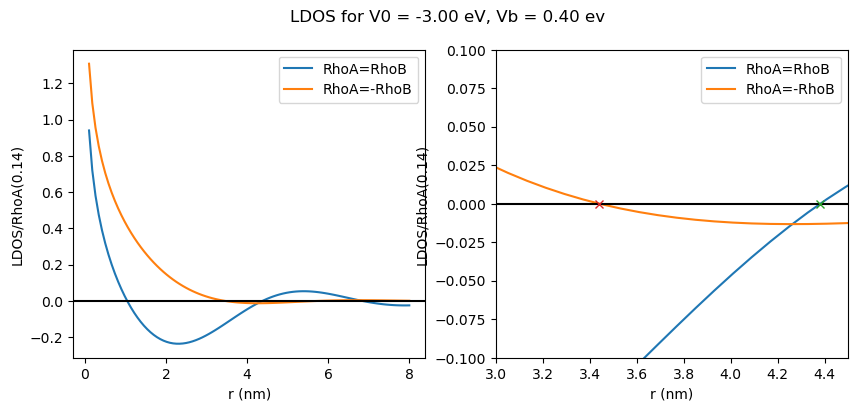

In [42]:
fig5, axs5 = plt.subplots(1, 2, figsize=(10, 4))


ycond1 = np.array([cond1(ri) for ri in rlist])
ycond2 = np.array([cond2(ri) for ri in rlist])

axs5[0].plot(rlist, ycond1)
axs5[0].plot(rlist, ycond2)
axs5[0].axhline(0, color="black")
axs5[0].legend(['RhoA=RhoB', 'RhoA=-RhoB'])
axs5[0].set_xlabel("r (nm)")
axs5[0].set_ylabel("LDOS/RhoA(0.14)")

axs5[1].plot(rlist, ycond1)
axs5[1].plot(rlist, ycond2)
axs5[1].axhline(0, color="black")
axs5[1].legend(['RhoA=RhoB', 'RhoA=-RhoB'])
axs5[1].set_xlabel("r (nm)")
axs5[1].set_ylabel("LDOS/RhoA(0.14)")
axs5[1].set_xlim(3, 4.5)
axs5[1].set_ylim(-0.1, 0.1)

axs5[1].plot(r1, 0, marker="x")
axs5[1].plot(r2, 0, marker="x")

#axs5.set_title(f"LDOS for V0 = {V0:.2f} eV, Vb = {thisVB:.2f} ev")

fig5.suptitle(f"LDOS for V0 = {V0:.2f} eV, Vb = {thisVB:.2f} ev")

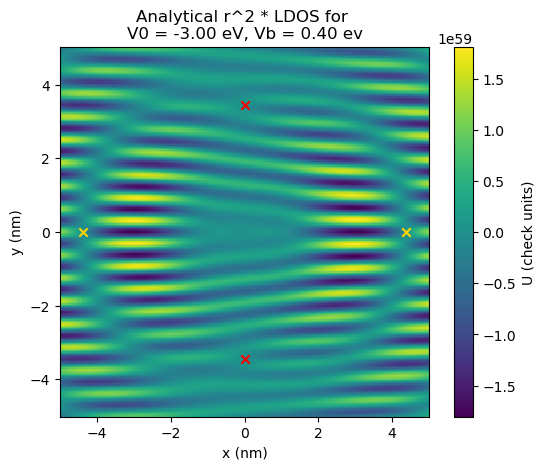

In [43]:
fig2, ax2 = plt.subplots()

#ax2.scatter(xx.flatten(), yy.flatten(), c=zz)
c = ax2.pcolormesh(xx, yy, zz)
fig2.colorbar(c, ax=ax2, label="U (check units)")
ax2.set_aspect('equal')
ax2.set_xlabel("x (nm)")
ax2.set_ylabel("y (nm)")
ax2.set_title(f"Analytical r^2 * LDOS for \nV0 = {V0:.2f} eV, Vb = {thisVB:.2f} ev")

# Adding calculated dislocation point case1
xd1, xd2 = r1 * np.cos(phi1[0]), r1 * np.cos(phi1[1])
yd1, yd2 = r1 * np.sin(phi1[0]), r1 * np.sin(phi1[1])
ax2.scatter([xd1, xd2], [yd1, yd2], color='gold', marker='x')

# Adding calculated dislocation point case2
xd1, xd2 = r2 * np.cos(phi2[0]), r2 * np.cos(phi2[1])
yd1, yd2 = r2 * np.sin(phi2[0]), r2 * np.sin(phi2[1])
ax2.scatter([xd1, xd2], [yd1, yd2], color='red', marker='x')

In [47]:
print(f"r1: {r1[0]:.4f} r2: {r2[0]:.4f}")

r1: 4.3815 r2: 3.4416


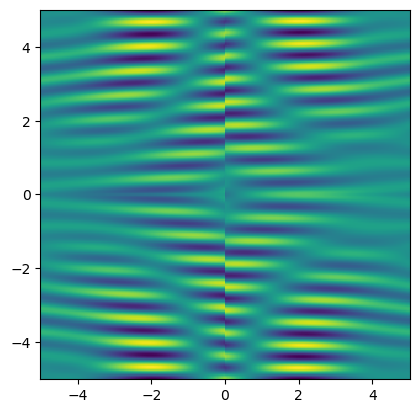

In [45]:
# Try an FFT
fig6, ax6 = plt.subplots()

ftz = np.fft.fft2(zz) # Remember this is LDOS times r**2
ftz = np.fft.fftshift(zz)

# Log scale height
plz = np.log(np.abs(ftz ** 2))

ax6.set_aspect('equal')

ax6.pcolormesh(xx, yy, ftz)